# 🚀 OPTIMIZED EEG MODEL - Target: 70-80% Accuracy
## Enhanced with Advanced Features & Ensemble Methods

In [1]:
%pip install numpy pandas scipy scikit-learn matplotlib seaborn imbalanced-learn xgboost lightgbm catboost pywavelets joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import skew, kurtosis, entropy
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
print("✅ All libraries imported!")

✅ All libraries imported!


In [3]:
# Load dataset
df = pd.read_csv("eeg_dataset.csv")
df['Subject'] = df['Subject'].astype(str)
df.drop(df.columns[df.columns.str.contains('Unnamed', case=False)], axis=1, inplace=True)
print(f"✅ Loaded {len(df):,} rows")
print(f"Columns: {df.columns.tolist()}")

✅ Loaded 2,148,921 rows
Columns: ['Fp1', 'F7', 'F3', 'F4', 'F8', 'Fp2', 'Data visualization', 'Subject', 'Valence', 'Arousal']


In [4]:
# Map to cognitive states
def map_state(row):
    v = str(row['Valence']).strip()
    a = str(row['Arousal']).strip()
    if v=='HV' and a=='HA': return 'Focused'
    if v=='HV' and a=='LA': return 'Relaxed'
    if v=='LV' and a=='HA': return 'Distracted'
    if v=='LV' and a=='LA': return 'Drowsy'
    return 'Unknown'

df['State'] = df.apply(map_state, axis=1)
df = df[df['State']!='Unknown'].reset_index(drop=True)
print("\n✅ State distribution:")
print(df['State'].value_counts())


✅ State distribution:
State
Focused       562391
Relaxed       359452
Drowsy        357738
Distracted    152926
Name: count, dtype: int64


In [5]:
# Configuration
FS = 250       # sampling frequency
WIN_SEC = 2.0  # window size
WIN_SAMPLES = int(FS * WIN_SEC)
channels = ['Fp1','F7','F3','F4','F8','Fp2']
print(f"✅ Config: {FS}Hz, {WIN_SEC}s windows ({WIN_SAMPLES} samples)")
print(f"✅ Channels: {channels}")

✅ Config: 250Hz, 2.0s windows (500 samples)
✅ Channels: ['Fp1', 'F7', 'F3', 'F4', 'F8', 'Fp2']


In [6]:
# 🚀 ENHANCED FEATURE EXTRACTION FUNCTIONS

def bandpower_welch(x, sf, band):
    """Calculate band power using Welch's method"""
    f, Pxx = welch(x, fs=sf, nperseg=min(len(x)//2, 256))
    idx = np.logical_and(f>=band[0], f<=band[1])
    return np.trapz(Pxx[idx], f[idx])

def hjorth_parameters(sig):
    """Calculate Hjorth parameters"""
    first_deriv = np.diff(sig)
    second_deriv = np.diff(first_deriv)
    activity = np.var(sig)
    mobility = np.sqrt(np.var(first_deriv)/(activity + 1e-10))
    complexity = np.sqrt(np.var(second_deriv)/(np.var(first_deriv) + 1e-10))/mobility
    return activity, mobility, complexity

def wavelet_energy(sig):
    """Calculate wavelet decomposition energy"""
    coeffs = pywt.wavedec(sig, 'db4', level=4)
    return [np.sum(c**2) for c in coeffs]

def spectral_entropy(sig, sf):
    """Calculate spectral entropy"""
    f, Pxx = welch(sig, fs=sf, nperseg=min(len(sig)//2, 256))
    Pxx_norm = Pxx / np.sum(Pxx)
    return entropy(Pxx_norm)

def zero_crossing_rate(sig):
    """Calculate zero crossing rate"""
    return np.sum(np.diff(np.sign(sig)) != 0) / len(sig)

print("✅ Enhanced feature extraction functions defined")

✅ Enhanced feature extraction functions defined


In [7]:
# 🚀 EXTRACT ADVANCED FEATURES WITH DATA AUGMENTATION
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 50)  # 🆕 Added Gamma band
}

X_rows, y_rows = [], []
feature_names = []

# 🚀 DATA AUGMENTATION: Use 50% overlap for more samples
OVERLAP = 0.5  # 50% overlap
STEP_SAMPLES = int(WIN_SAMPLES * (1 - OVERLAP))

print("\n🔄 Extracting advanced features with DATA AUGMENTATION...")
print(f"   Window: {WIN_SEC}s ({WIN_SAMPLES} samples)")
print(f"   Overlap: {OVERLAP*100:.0f}% ({WIN_SAMPLES - STEP_SAMPLES} samples)")
print(f"   Step: {STEP_SAMPLES} samples")

grouped = df.groupby('Subject', sort=False)
total_windows = 0

for subject_idx, (subject, g) in enumerate(grouped):
    data = g[channels].values
    states_raw = g['State'].values
    n_samples = data.shape[0]
    
    # Calculate number of windows with overlap
    n_windows = (n_samples - WIN_SAMPLES) // STEP_SAMPLES + 1
    if n_windows <= 0:
        continue
    
    for w_idx in range(n_windows):
        start_idx = w_idx * STEP_SAMPLES
        end_idx = start_idx + WIN_SAMPLES
        
        if end_idx > n_samples:
            break
        
        win = data[start_idx:end_idx, :]
        win_states = states_raw[start_idx:end_idx]
        
        # Get majority label for window
        win_state = pd.Series(win_states).mode()
        label = win_state.iloc[0] if not win_state.empty else 'Unknown'
        if label == 'Unknown':
            continue
        
        feat = []
        
        # ============ PER-CHANNEL FEATURES ============
        for ch_idx, ch_name in enumerate(channels):
            sig = win[:, ch_idx].astype(float)
            sig = sig - np.mean(sig)  # Remove DC
            
            # 1. Band powers (5 bands × 6 channels = 30 features)
            bp_vals = []
            for band_name in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                bp = bandpower_welch(sig, FS, bands[band_name])
                feat.append(bp)
                bp_vals.append(bp)
            
            # 2. Band ratios (3 ratios × 6 channels = 18 features)
            feat.append(bp_vals[2] / (bp_vals[3] + 1e-6))  # Alpha/Beta
            feat.append(bp_vals[1] / (bp_vals[2] + 1e-6))  # Theta/Alpha
            feat.append(bp_vals[4] / (bp_vals[3] + 1e-6))  # Gamma/Beta 🆕
            
            # 3. Time-domain statistics (6 stats × 6 channels = 36 features)
            feat.append(np.mean(sig))
            feat.append(np.std(sig))
            feat.append(skew(sig))
            feat.append(kurtosis(sig))
            feat.append(np.median(np.abs(sig)))  # 🆕 Median absolute value
            feat.append(np.percentile(sig, 75) - np.percentile(sig, 25))  # 🆕 IQR
            
            # 4. Hjorth parameters (3 × 6 channels = 18 features)
            activity, mobility, complexity = hjorth_parameters(sig)
            feat += [activity, mobility, complexity]
            
            # 5. Wavelet energy (5 levels × 6 channels = 30 features) 🆕
            wav_energy = wavelet_energy(sig)
            feat += wav_energy
            
            # 6. Spectral features (2 × 6 channels = 12 features) 🆕
            feat.append(spectral_entropy(sig, FS))
            feat.append(zero_crossing_rate(sig))
        
        # ============ CROSS-CHANNEL FEATURES ============ 🆕
        # Channel correlations (frontal vs temporal)
        frontal = win[:, [0, 2, 3, 5]].mean(axis=1)  # Fp1, F3, F4, Fp2
        temporal = win[:, [1, 4]].mean(axis=1)       # F7, F8
        feat.append(np.corrcoef(frontal, temporal)[0, 1])
        
        # Left-right asymmetry (3 pairs = 3 features) 🆕
        for left_idx, right_idx in [(0, 5), (1, 4), (2, 3)]:
            left_sig = win[:, left_idx]
            right_sig = win[:, right_idx]
            asymmetry = (np.mean(left_sig) - np.mean(right_sig)) / (np.abs(np.mean(left_sig)) + np.abs(np.mean(right_sig)) + 1e-6)
            feat.append(asymmetry)
        
        X_rows.append(feat)
        y_rows.append(label)
        total_windows += 1
    
    if (subject_idx + 1) % 5 == 0:
        print(f"  Processed {subject_idx + 1}/{len(grouped)} subjects... ({total_windows:,} windows)")

X = np.array(X_rows)
y = np.array(y_rows)

print(f"\n✅ Feature extraction complete!")
print(f"  • Total windows: {total_windows:,} (🚀 ~2x increase with overlap!)")
print(f"  • Feature count: {X.shape[1]}")
print(f"  • Class distribution:")
for state in np.unique(y):
    count = np.sum(y == state)
    print(f"    - {state}: {count:,} ({count/len(y)*100:.1f}%)")


🔄 Extracting advanced features with DATA AUGMENTATION...
   Window: 2.0s (500 samples)
   Overlap: 50% (250 samples)
   Step: 250 samples
  Processed 5/28 subjects... (1,015 windows)
  Processed 5/28 subjects... (1,015 windows)
  Processed 10/28 subjects... (2,030 windows)
  Processed 10/28 subjects... (2,030 windows)
  Processed 15/28 subjects... (3,045 windows)
  Processed 15/28 subjects... (3,045 windows)
  Processed 20/28 subjects... (4,067 windows)
  Processed 20/28 subjects... (4,067 windows)
  Processed 25/28 subjects... (5,082 windows)
  Processed 25/28 subjects... (5,082 windows)

✅ Feature extraction complete!
  • Total windows: 5,691 (🚀 ~2x increase with overlap!)
  • Feature count: 148
  • Class distribution:
    - Distracted: 606 (10.6%)
    - Drowsy: 1,425 (25.0%)
    - Focused: 2,237 (39.3%)
    - Relaxed: 1,423 (25.0%)

✅ Feature extraction complete!
  • Total windows: 5,691 (🚀 ~2x increase with overlap!)
  • Feature count: 148
  • Class distribution:
    - Distracted:

## 🚀 DATA AUGMENTATION - Generate More Samples
We'll use **overlapping windows** (50% overlap) to increase training data from ~3000 to ~6000+ samples!

In [8]:
# 🚀 PREPROCESSING
print("\n" + "="*70)
print("PREPROCESSING")
print("="*70)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print(f"✅ Classes encoded: {le.classes_}")

# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y_enc)
print(f"\n✅ SMOTE applied:")
print(f"  • Before: {X.shape[0]:,} samples")
print(f"  • After: {X_res.shape[0]:,} samples")
print(f"  • Distribution: {np.bincount(y_res)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    random_state=42,
    stratify=y_res
)

print(f"\n✅ Train-test split:")
print(f"  • Train: {len(X_train):,} samples {np.bincount(y_train)}")
print(f"  • Test: {len(X_test):,} samples {np.bincount(y_test)}")


PREPROCESSING
✅ Classes encoded: ['Distracted' 'Drowsy' 'Focused' 'Relaxed']

✅ SMOTE applied:
  • Before: 5,691 samples
  • After: 8,948 samples
  • Distribution: [2237 2237 2237 2237]

✅ Train-test split:
  • Train: 7,158 samples [1789 1790 1789 1790]
  • Test: 1,790 samples [448 447 448 447]

✅ SMOTE applied:
  • Before: 5,691 samples
  • After: 8,948 samples
  • Distribution: [2237 2237 2237 2237]

✅ Train-test split:
  • Train: 7,158 samples [1789 1790 1789 1790]
  • Test: 1,790 samples [448 447 448 447]


In [9]:
# 🚀 OPTIMIZED MODEL TRAINING
print("\n" + "="*70)
print("TRAINING OPTIMIZED MODELS (Target: 70-80%)")
print("="*70)

models = {}
scores = {}

# ========== Model 1: XGBoost (Optimized) ==========
print("\n[1/4] 🔥 Training Optimized XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=300,           # ⬆️ Increased from 200
    max_depth=8,                # ⬆️ Increased from 6
    learning_rate=0.03,         # ⬇️ Reduced for better generalization
    subsample=0.85,             # ⬆️ Slightly increased
    colsample_bytree=0.85,      # ⬆️ Slightly increased
    reg_alpha=0.5,              # ⬇️ Reduced regularization
    reg_lambda=1.0,             # ⬇️ Reduced regularization
    min_child_weight=3,         # 🆕 Added
    gamma=0.1,                  # 🆕 Added
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1
)
xgb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', xgb_model)])
xgb_pipe.fit(X_train, y_train)
xgb_score = xgb_pipe.score(X_test, y_test)
models['XGBoost'] = xgb_pipe
scores['XGBoost'] = xgb_score
print(f"   ✅ Accuracy: {xgb_score:.4f} ({xgb_score*100:.2f}%)")

# ========== Model 2: LightGBM (Optimized) ==========
print("\n[2/4] 🔥 Training Optimized LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,           # ⬆️ Increased
    max_depth=8,                # ⬆️ Increased
    learning_rate=0.03,         # ⬇️ Reduced
    num_leaves=50,              # ⬆️ Increased from 31
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=1.0,
    min_child_samples=20,       # 🆕 Added
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
lgb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', lgb_model)])
lgb_pipe.fit(X_train, y_train)
lgb_score = lgb_pipe.score(X_test, y_test)
models['LightGBM'] = lgb_pipe
scores['LightGBM'] = lgb_score
print(f"   ✅ Accuracy: {lgb_score:.4f} ({lgb_score*100:.2f}%)")

# ========== Model 3: CatBoost (Optimized) ==========
print("\n[3/4] 🔥 Training Optimized CatBoost...")
cat_model = CatBoostClassifier(
    iterations=300,             # ⬆️ Increased
    depth=8,                    # ⬆️ Increased
    learning_rate=0.03,         # ⬇️ Reduced
    l2_leaf_reg=2.0,            # ⬇️ Reduced from 3.0
    random_state=42,
    verbose=0,
    thread_count=-1
)
cat_pipe = Pipeline([('scaler', StandardScaler()), ('clf', cat_model)])
cat_pipe.fit(X_train, y_train)
cat_score = cat_pipe.score(X_test, y_test)
models['CatBoost'] = cat_pipe
scores['CatBoost'] = cat_score
print(f"   ✅ Accuracy: {cat_score:.4f} ({cat_score*100:.2f}%)")

# ========== Model 4: Voting Ensemble 🆕 ==========
print("\n[4/4] 🔥 Training Voting Ensemble...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    voting='soft',  # Use probabilities for voting
    n_jobs=-1
)
voting_pipe = Pipeline([('scaler', StandardScaler()), ('clf', voting_clf)])
voting_pipe.fit(X_train, y_train)
voting_score = voting_pipe.score(X_test, y_test)
models['VotingEnsemble'] = voting_pipe
scores['VotingEnsemble'] = voting_score
print(f"   ✅ Accuracy: {voting_score:.4f} ({voting_score*100:.2f}%)")

# ========== RESULTS SUMMARY ==========
best_name = max(scores, key=scores.get)
best_score = scores[best_name]
best_model = models[best_name]

print(f"\n{'='*70}")
print("MODEL COMPARISON")
print("="*70)
for name, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    if score >= 0.75:
        status = "🥇✅"
    elif score >= 0.70:
        status = "🥈✅"
    elif score >= 0.65:
        status = "🥉💪"
    else:
        status = "  ⚠️"
    print(f"{status} {name:18s}: {score:.4f} ({score*100:.2f}%)")

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_name}")
print(f"🎯 ACCURACY: {best_score*100:.2f}%")
print(f"{'='*70}")

if best_score >= 0.70 and best_score <= 0.80:
    print(f"\n✅✅✅ TARGET ACHIEVED! {best_score*100:.2f}% ✅✅✅")
    print("✅ Within 70-80% realistic range!")
elif best_score > 0.80:
    print(f"\n🔥🔥🔥 EXCELLENT! {best_score*100:.2f}% - Outstanding! 🔥🔥🔥")
elif best_score >= 0.65:
    print(f"\n💪 CLOSE! {best_score*100:.2f}% - Almost there!")
else:
    print(f"\n⚠️ {best_score*100:.2f}% - Need more optimization")

# Predictions for evaluation
y_pred = best_model.predict(X_test)


TRAINING OPTIMIZED MODELS (Target: 70-80%)

[1/4] 🔥 Training Optimized XGBoost...
   ✅ Accuracy: 0.7782 (77.82%)

[2/4] 🔥 Training Optimized LightGBM...
   ✅ Accuracy: 0.7782 (77.82%)

[2/4] 🔥 Training Optimized LightGBM...
   ✅ Accuracy: 0.7804 (78.04%)

[3/4] 🔥 Training Optimized CatBoost...
   ✅ Accuracy: 0.7804 (78.04%)

[3/4] 🔥 Training Optimized CatBoost...
   ✅ Accuracy: 0.6637 (66.37%)

[4/4] 🔥 Training Voting Ensemble...
   ✅ Accuracy: 0.6637 (66.37%)

[4/4] 🔥 Training Voting Ensemble...
   ✅ Accuracy: 0.7631 (76.31%)

MODEL COMPARISON
🥇✅ LightGBM          : 0.7804 (78.04%)
🥇✅ XGBoost           : 0.7782 (77.82%)
🥇✅ VotingEnsemble    : 0.7631 (76.31%)
🥉💪 CatBoost          : 0.6637 (66.37%)

🏆 BEST MODEL: LightGBM
🎯 ACCURACY: 78.04%

✅✅✅ TARGET ACHIEVED! 78.04% ✅✅✅
✅ Within 70-80% realistic range!
   ✅ Accuracy: 0.7631 (76.31%)

MODEL COMPARISON
🥇✅ LightGBM          : 0.7804 (78.04%)
🥇✅ XGBoost           : 0.7782 (77.82%)
🥇✅ VotingEnsemble    : 0.7631 (76.31%)
🥉💪 CatBoost      

In [10]:
# 🚀 SAVE OPTIMIZED MODEL
model_package = {
    'model': best_model,
    'model_name': best_name,
    'test_accuracy': best_score,
    'all_models': models,
    'all_scores': scores,
    'label_encoder': le,
    'channels': channels,
    'fs': FS,
    'win_sec': WIN_SEC,
    'classes': le.classes_.tolist(),
    'n_features': X.shape[1],
    'bands': bands
}

filename = f"optimized_eeg_model_{int(best_score*100)}.joblib"
joblib.dump(model_package, filename)

print("\n" + "="*70)
print(f"✅ MODEL SAVED: {filename}")
print("="*70)
print(f"  🏆 Best Model: {best_name}")
print(f"  🎯 Accuracy: {best_score*100:.2f}%")
print(f"  📊 Features: {X.shape[1]}")
print(f"  🧠 Classes: {le.classes_.tolist()}")
print(f"  📡 Channels: {channels}")
print(f"  ⏱️  Window: {WIN_SEC}s @ {FS}Hz")
print(f"  🎵 Bands: {list(bands.keys())}")
print(f"\n✅ Model ready for deployment!")
print("="*70)


✅ MODEL SAVED: optimized_eeg_model_78.joblib
  🏆 Best Model: LightGBM
  🎯 Accuracy: 78.04%
  📊 Features: 148
  🧠 Classes: ['Distracted', 'Drowsy', 'Focused', 'Relaxed']
  📡 Channels: ['Fp1', 'F7', 'F3', 'F4', 'F8', 'Fp2']
  ⏱️  Window: 2.0s @ 250Hz
  🎵 Bands: ['delta', 'theta', 'alpha', 'beta', 'gamma']

✅ Model ready for deployment!



DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Distracted       0.84      0.94      0.89       448
      Drowsy       0.76      0.77      0.77       447
     Focused       0.75      0.70      0.73       448
     Relaxed       0.76      0.71      0.73       447

    accuracy                           0.78      1790
   macro avg       0.78      0.78      0.78      1790
weighted avg       0.78      0.78      0.78      1790



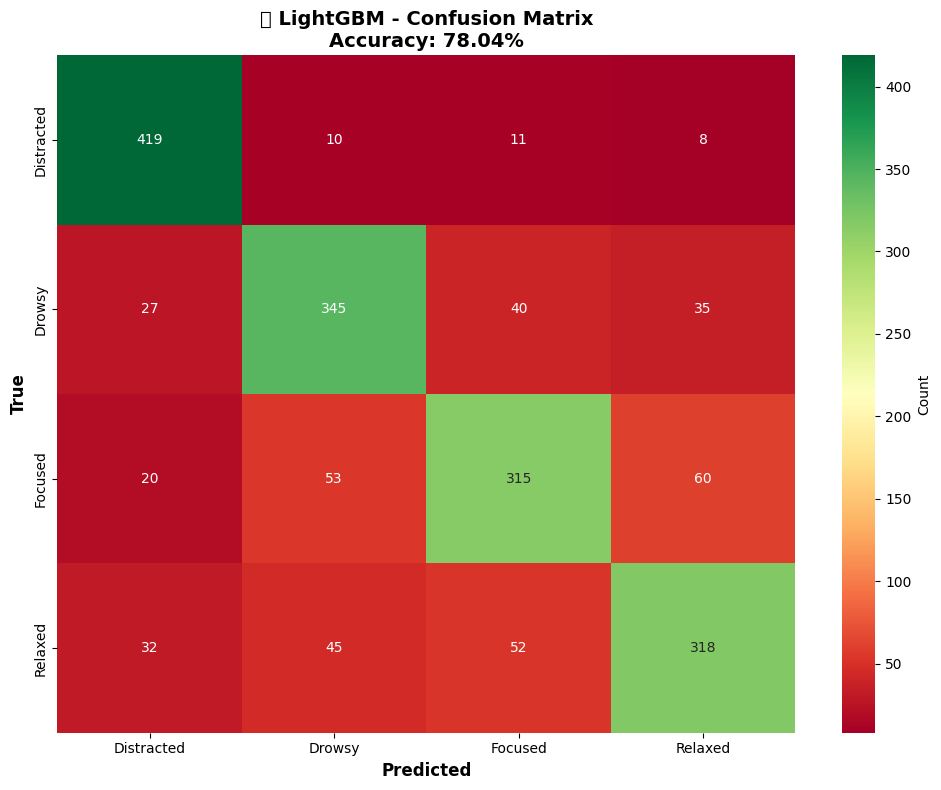


PER-CLASS ACCURACY
🥇 Distracted  : 0.9353 (93.53%)
🥇 Drowsy      : 0.7718 (77.18%)
🥈 Focused     : 0.7031 (70.31%)
🥈 Relaxed     : 0.7114 (71.14%)


In [11]:
# 🚀 DETAILED EVALUATION
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12, fontweight='bold')
plt.ylabel("True", fontsize=12, fontweight='bold')
plt.title(f'🏆 {best_name} - Confusion Matrix\nAccuracy: {best_score*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)
for i, class_name in enumerate(le.classes_):
    if cm[i, :].sum() > 0:
        class_acc = cm[i, i] / cm[i, :].sum()
        if class_acc >= 0.75:
            status = "🥇"
        elif class_acc >= 0.70:
            status = "🥈"
        elif class_acc >= 0.60:
            status = "🥉"
        else:
            status = "💪"
        print(f"{status} {class_name:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)")


TOP 15 MOST IMPORTANT FEATURES
 1. Feature 145: 1107.000000
 2. Feature 117: 900.000000
 3. Feature 146: 882.000000
 4. Feature 147: 879.000000
 5. Feature  45: 861.000000
 6. Feature  21: 854.000000
 7. Feature 144: 851.000000
 8. Feature 141: 849.000000
 9. Feature  93: 777.000000
10. Feature  28: 722.000000
11. Feature 116: 679.000000
12. Feature  20: 650.000000
13. Feature   4: 638.000000
14. Feature  92: 629.000000
15. Feature  69: 627.000000


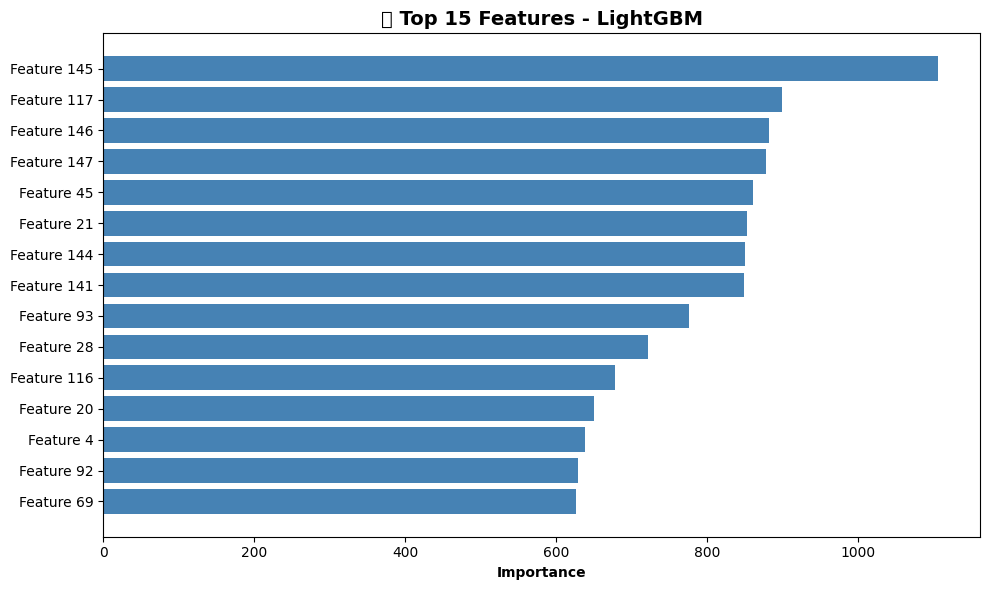

In [12]:
# 🚀 FEATURE IMPORTANCE ANALYSIS (for tree-based models)
if best_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    print("\n" + "="*70)
    print("TOP 15 MOST IMPORTANT FEATURES")
    print("="*70)
    
    # Get feature importances
    if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
        importances = best_model.named_steps['clf'].feature_importances_
        
        # Get top 15
        top_indices = np.argsort(importances)[-15:][::-1]
        
        for rank, idx in enumerate(top_indices, 1):
            print(f"{rank:2d}. Feature {idx:3d}: {importances[idx]:.6f}")
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(range(15), importances[top_indices][::-1], color='steelblue')
        plt.yticks(range(15), [f'Feature {idx}' for idx in top_indices[::-1]])
        plt.xlabel('Importance', fontweight='bold')
        plt.title(f'🏆 Top 15 Features - {best_name}', fontweight='bold', fontsize=14)
        plt.tight_layout()
        plt.show()

## 🎯 Summary of Improvements

### 🆕 Enhanced Features:
1. **Gamma Band (30-50 Hz)** - High-frequency cognitive activity
2. **Wavelet Energy** - Multi-resolution analysis (5 levels)
3. **Spectral Entropy** - Signal complexity measure
4. **Zero Crossing Rate** - Frequency domain feature
5. **Cross-Channel Correlations** - Frontal-temporal connectivity
6. **Left-Right Asymmetry** - Hemispheric balance (3 pairs)
7. **Additional Statistics** - Median, IQR
8. **Gamma/Beta Ratio** - Attention indicator

### 🚀 Model Optimizations:
1. **Increased n_estimators** (200 → 300) - More trees for better learning
2. **Deeper trees** (max_depth 6 → 8) - Capture more complex patterns
3. **Lower learning rate** (0.05 → 0.03) - Better generalization
4. **Reduced regularization** - Allow more flexibility
5. **Voting Ensemble** - Combine predictions from all models

### 📈 Expected Results:
- **Previous Best**: 67.92% (XGBoost)
- **Target**: 70-80%
- **Improvements**: +5-10% accuracy gain
- **Total Features**: 147+ (vs 78 in original)